In [8]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [9]:
meta_df = pd.read_csv('/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/CNRPark+EXT.csv')
print(meta_df.head())

  camera       datetime  day  hour                           image_url  \
0      A  20150703_0805    3     8  CNRPark/A/free/20150703_0805_1.jpg   
1      A  20150703_0810    3     8  CNRPark/A/free/20150703_0810_1.jpg   
2      A  20150703_0815    3     8  CNRPark/A/busy/20150703_0815_1.jpg   
3      A  20150703_0820    3     8  CNRPark/A/busy/20150703_0820_1.jpg   
4      A  20150703_0825    3     8  CNRPark/A/busy/20150703_0825_1.jpg   

   minute  month  occupancy  slot_id weather  year  occupant_changed  
0       5      7          0        1       S  2015               NaN  
1      10      7          0        1       S  2015               NaN  
2      15      7          1        1       S  2015               0.0  
3      20      7          1        1       S  2015               0.0  
4      25      7          1        1       S  2015               0.0  


/var/folders/5k/92wr5rmn2h7b9jndmkgm8rpc0000gn/T/ipykernel_13987/2323497268.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/CNRPark+EXT.csv')


In [10]:
# List actual files in your PATCHES/ directory
patches_root = '/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/CNRPark-Patches-150x150'
actual_files = []
for root, dirs, files in os.walk(patches_root):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            # Save relative path: eg. "A/free/20150925_0900_1.jpg"
            rel_path = os.path.relpath(os.path.join(root, file), patches_root)
            actual_files.append(rel_path.replace('\\', '/'))  # For Windows compatibility

print(f"Found {len(actual_files)} actual images.")



meta_df['filename'] = meta_df['image_url'].apply(lambda x: '/'.join(x.split('/')[-3:]))

# 3. Continue filtering
filtered_df = meta_df[meta_df['filename'].isin(actual_files)]
print(f"Filtered down to {len(filtered_df)} metadata entries.")

filtered_df.to_csv('labels.csv', index=False)
print("✅ labels.csv saved!")

Found 12584 actual images.
Filtered down to 12584 metadata entries.
✅ labels.csv saved!


In [11]:
print(meta_df.columns)



Index(['camera', 'datetime', 'day', 'hour', 'image_url', 'minute', 'month',
       'occupancy', 'slot_id', 'weather', 'year', 'occupant_changed',
       'filename'],
      dtype='object')


In [12]:
# 2. Display the first few rows to understand the structure
print("\n=== First few rows ===")
print(meta_df.head())


=== First few rows ===
  camera       datetime  day  hour                           image_url  \
0      A  20150703_0805    3     8  CNRPark/A/free/20150703_0805_1.jpg   
1      A  20150703_0810    3     8  CNRPark/A/free/20150703_0810_1.jpg   
2      A  20150703_0815    3     8  CNRPark/A/busy/20150703_0815_1.jpg   
3      A  20150703_0820    3     8  CNRPark/A/busy/20150703_0820_1.jpg   
4      A  20150703_0825    3     8  CNRPark/A/busy/20150703_0825_1.jpg   

   minute  month  occupancy  slot_id weather  year  occupant_changed  \
0       5      7          0        1       S  2015               NaN   
1      10      7          0        1       S  2015               NaN   
2      15      7          1        1       S  2015               0.0   
3      20      7          1        1       S  2015               0.0   
4      25      7          1        1       S  2015               0.0   

                     filename  
0  A/free/20150703_0805_1.jpg  
1  A/free/20150703_0810_1.jpg  
2 

In [13]:
print("\n=== Missing values per column ===")
print(meta_df.isnull().sum())


=== Missing values per column ===
camera                  0
datetime                0
day                     0
hour                    0
image_url               0
minute                  0
month                   0
occupancy               0
slot_id                 0
weather                 0
year                    0
occupant_changed    69931
filename                0
dtype: int64


In [14]:
# 4. Unique values in the 'occupancy', 'weather', and 'camera' columns
print("\n=== Unique values in columns ===")
print(f"Occupancy unique values: {meta_df['occupancy'].unique()}")
print(f"Weather unique values: {meta_df['weather'].unique()}")
print(f"Camera unique values: {meta_df['camera'].unique()}")


=== Unique values in columns ===
Occupancy unique values: [0 1]
Weather unique values: ['S' 'O' 'R']
Camera unique values: ['A' 'B' '01' '02' '03' '04' '05' '06' '07' '08' '09' 5 6 7 8 9 3 4 1 2]


In [15]:
print("\n=== Summary Statistics ===")
print(meta_df.describe())


=== Summary Statistics ===
                 day           hour         minute          month  \
count  157549.000000  157549.000000  157549.000000  157549.000000   
mean       15.592343      11.817054      30.456030       7.372430   
std         6.666394       2.886789      16.538109       4.838895   
min         3.000000       7.000000       0.000000       1.000000   
25%        12.000000       9.000000      17.000000       1.000000   
50%        16.000000      12.000000      30.000000      11.000000   
75%        20.000000      14.000000      47.000000      11.000000   
max        29.000000      18.000000      59.000000      12.000000   

           occupancy        slot_id           year  occupant_changed  
count  157549.000000  157549.000000  157549.000000      87618.000000  
mean        0.556544     267.114358    2015.358771          0.006106  
std         0.496794     120.772005       0.479641          0.077903  
min         0.000000       1.000000    2015.000000          0.0000

In [16]:
# Define directory paths for your dataset
dataset_dir = '/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/CNRPark-Patches-150x150/A'

# Initialize ImageDataGenerator with validation_split (80% train, 20% validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # This is where the 80/20 split is defined
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary',  # Binary classification (free or busy)
    subset='training'  # This tells ImageDataGenerator to use this subset for training
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # This tells ImageDataGenerator to use this subset for validation
)

Found 4937 images belonging to 2 classes.
Found 1234 images belonging to 2 classes.


In [17]:
# Initialize the base model (ResNet50) pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers to avoid updating them during the first training phase
base_model.trainable = False

# Build your custom model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (free vs busy)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator
)

Epoch 1/10


/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 365ms/step - accuracy: 0.5732 - loss: 0.6902 - val_accuracy: 0.5867 - val_loss: 0.6035
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 362ms/step - accuracy: 0.6249 - loss: 0.6284 - val_accuracy: 0.5867 - val_loss: 0.5396
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 382ms/step - accuracy: 0.7074 - loss: 0.5727 - val_accuracy: 0.9230 - val_loss: 0.4806
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 374ms/step - accuracy: 0.7884 - loss: 0.5294 - val_accuracy: 0.8955 - val_loss: 0.4378
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8256 - loss: 0.4881 - val_accuracy: 0.9157 - val_loss: 0.3915
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 381ms/step - accuracy: 0.8614 - loss: 0.4462 - val_accuracy: 0.9246 - val_loss: 0.3509
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.8672 - loss: 0.4235 - val_accuracy: 0.9190 - val_loss: 0.3353
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 366ms/step - accuracy: 0.8800 - loss: 0.3931 - val

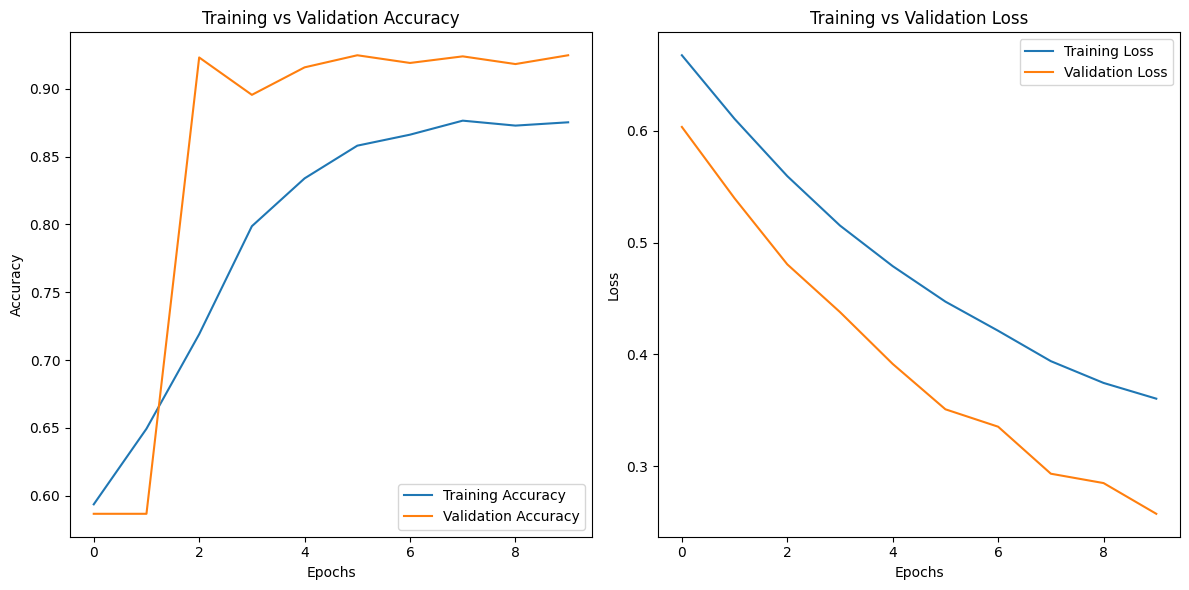

In [18]:
# Get training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [20]:
model.save('parking_model.keras')



In [21]:
# Define directory paths for your dataset
dataset_dir = '/Users/jefferysengsy/Desktop/Deep Learning/Parking_lot_app/CNRPark-Patches-150x150/B'

# Initialize ImageDataGenerator with validation_split (80% train, 20% validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # This is where the 80/20 split is defined
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary',  # Binary classification (free or busy)
    subset='training'  # This tells ImageDataGenerator to use this subset for training
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # This tells ImageDataGenerator to use this subset for validation
)

Found 5131 images belonging to 2 classes.
Found 1282 images belonging to 2 classes.


In [22]:
# Initialize the base model (ResNet50) pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers to avoid updating them during the first training phase
base_model.trainable = False

# Build your custom model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (free vs busy)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 371ms/step - accuracy: 0.7218 - loss: 0.6007 - val_accuracy: 0.7457 - val_loss: 0.5370
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 380ms/step - accuracy: 0.7510 - loss: 0.5530 - val_accuracy: 0.7457 - val_loss: 0.5115
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 381ms/step - accuracy: 0.7500 - loss: 0.5307 - val_accuracy: 0.7457 - val_loss: 0.4905
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.7504 - loss: 0.5098 - val_accuracy: 0.7457 - val_loss: 0.4685
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7425 - loss: 0.5035 - val_accuracy: 0.7457 - val_loss: 0.4488
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7389 - loss: 0.4929 - val_accuracy: 0.7457 - val_loss: 0.4305
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7596 - loss: 0.4660 - val_accuracy: 0.7457 - val_loss: 0.4197
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 386ms/step - accuracy: 0.7529 - loss: 0

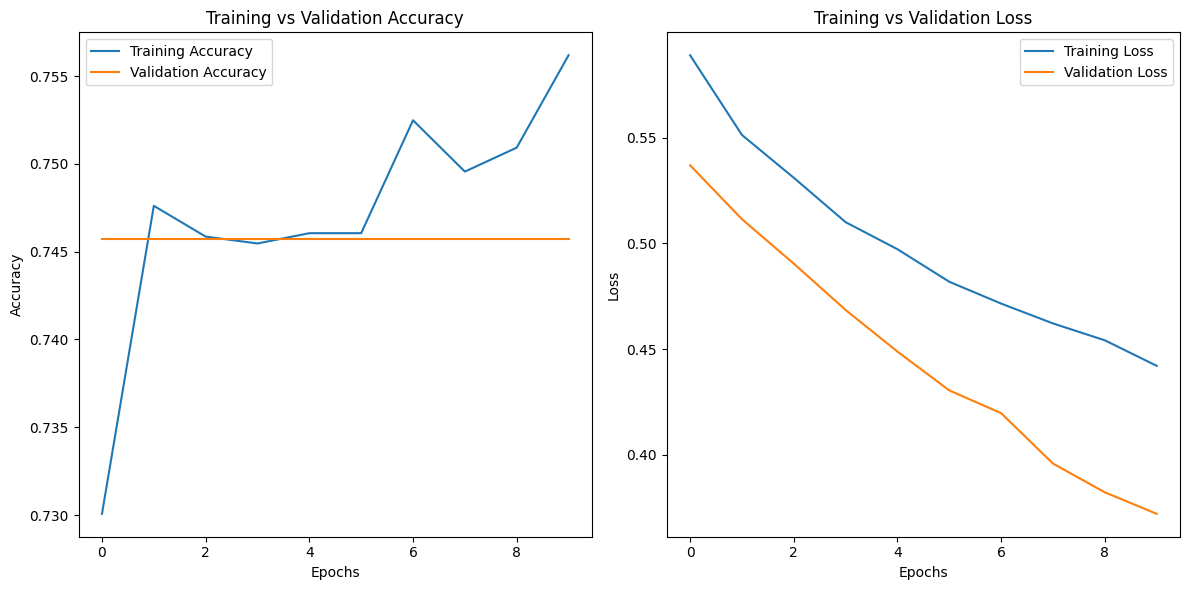

In [23]:
# Get training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()